# Visualization of Augmentations

This notebook verifies that the bounding boxes are correctly preserved and transformed along with the images during the data loading process.

In [7]:
import os
import cv2
import torch
import yaml
import random
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import v2
from torchvision import tv_tensors

# Import YOLODataset from train_custom.py to ensure consistency
import sys
sys.path.append(os.getcwd())
from train import YOLODataset, xywhn2xyxy, xyxy2xywhn


In [8]:
# --- Configuration ---
class Args:
    data = 'datasets/unified/data.yaml'
    imgsz = 640
    mosaic = 0.5

args = Args()

# Load class names
with open(args.data, 'r') as f:
    data_cfg = yaml.safe_load(f)
class_names = data_cfg['names']

# Define Transforms
train_transform = v2.Compose([
        v2.Resize((args.imgsz, args.imgsz)),
        v2.RandomAffine(
            degrees=15,           # Rotation ±15°
            translate=(0.1, 0.1), # Translation 10%
            scale=(0.5, 1.5),     # Scale 50%-150%
            shear=10              # Shear ±10°
        ),
        v2.ColorJitter(
            brightness=0.5,
            contrast=0.5,
            saturation=0.7,
            hue=0.015
        ),
        v2.RandomGrayscale(p=0.1),  # 10% chance grayscale
    ])

# Initialize Dataset
dataset = YOLODataset(args.data, split='train', img_size=args.imgsz, transform=train_transform, mosaic_prob=args.mosaic)
print(f"Dataset size: {len(dataset)}")

Dataset size: 52335


Displaying random augmented samples...

Sample 28133:
Targets shape: torch.Size([1, 5])
Targets content:
tensor([[10.0000,  0.1572,  0.1635,  0.0436,  0.0589]])
Visualizing sample with 1 targets
Box: 3h at [86, 85, 114, 123]


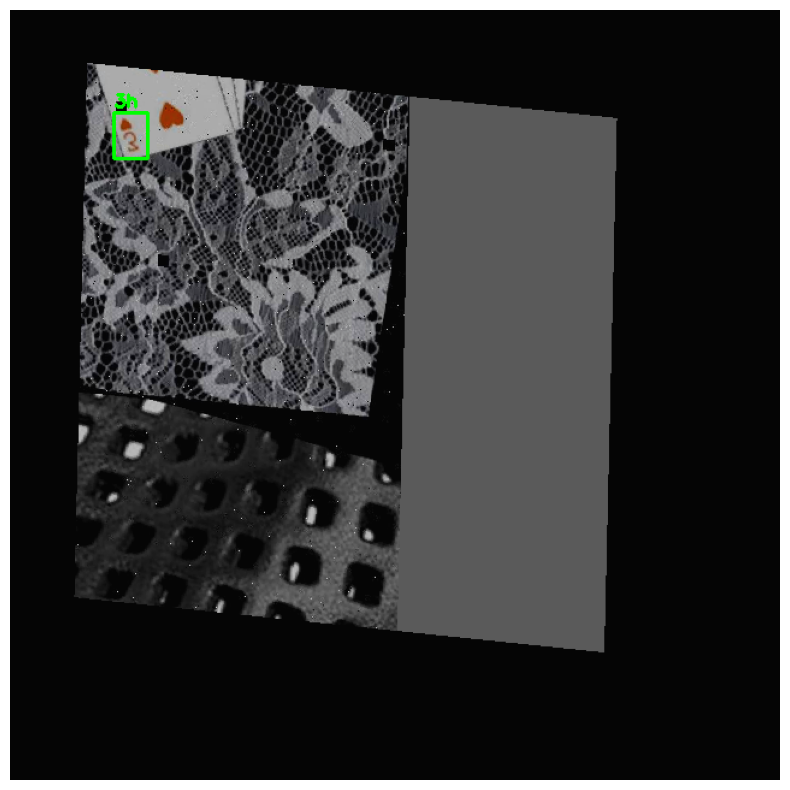


Sample 20034:
Targets shape: torch.Size([2, 5])
Targets content:
tensor([[5.0000, 0.3360, 0.3854, 0.1129, 0.1335],
        [5.0000, 0.6943, 0.5852, 0.0918, 0.1268]])
Visualizing sample with 2 targets
Box: 2d at [178, 203, 251, 289]
Box: 2d at [414, 333, 473, 415]


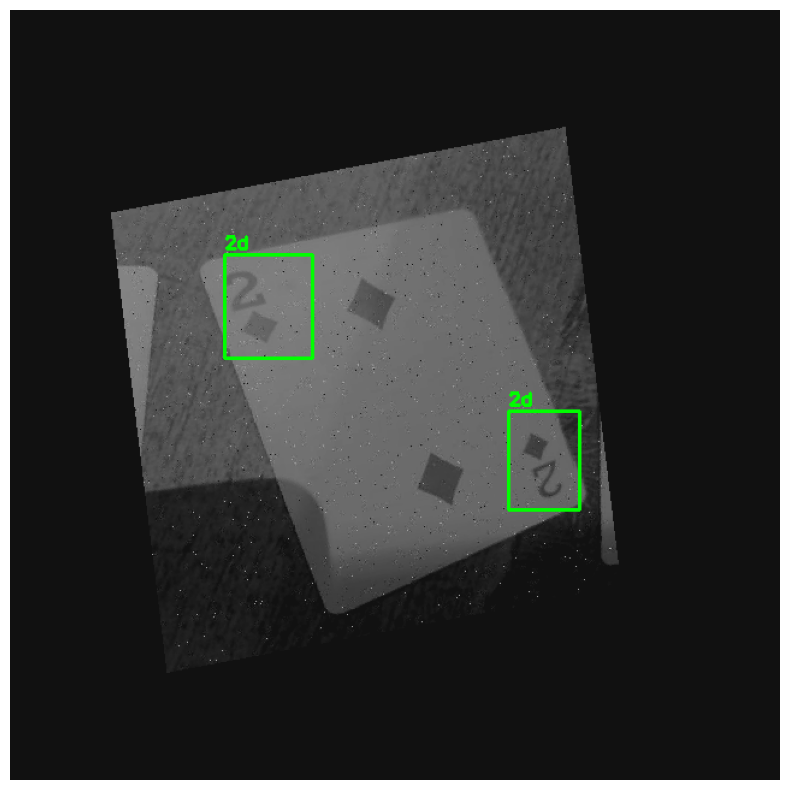


Sample 7291:
Targets shape: torch.Size([4, 5])
Targets content:
tensor([[11.0000,  0.6616,  0.2747,  0.1472,  0.1167],
        [11.0000,  0.3354,  0.8566,  0.1489,  0.1169],
        [36.0000,  0.6518,  0.4555,  0.1172,  0.1283],
        [36.0000,  0.0462,  0.4209,  0.0925,  0.1318]])
Visualizing sample with 4 targets
Box: 3s at [376, 138, 470, 213]
Box: 3s at [167, 510, 262, 585]
Box: Ac at [379, 250, 454, 332]
Box: Ac at [0, 227, 59, 311]


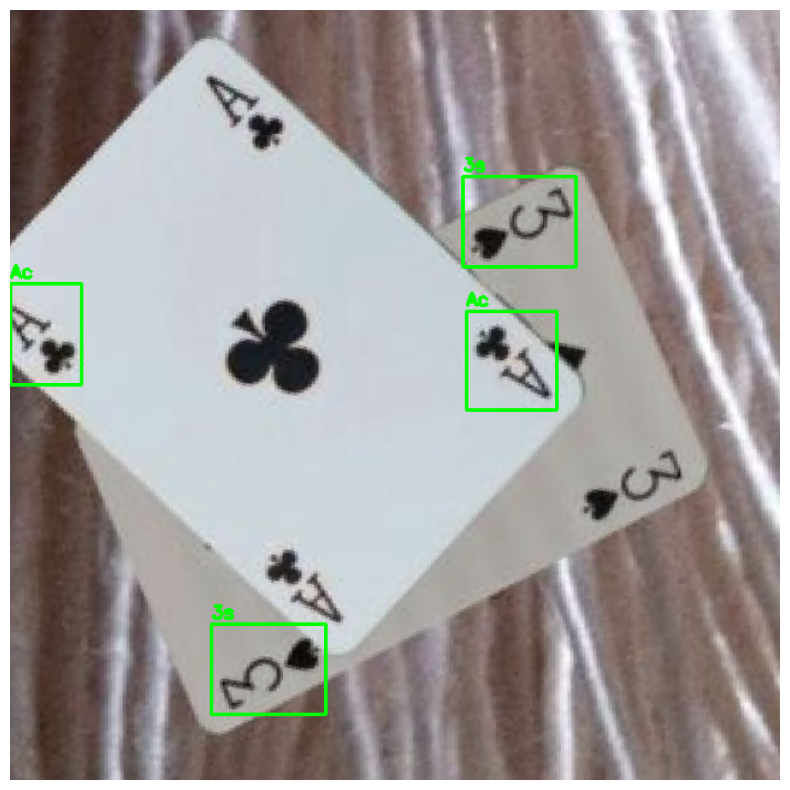


Sample 3925:
Targets shape: torch.Size([0, 5])
Targets content:
tensor([], size=(0, 5))
Visualizing sample with 0 targets


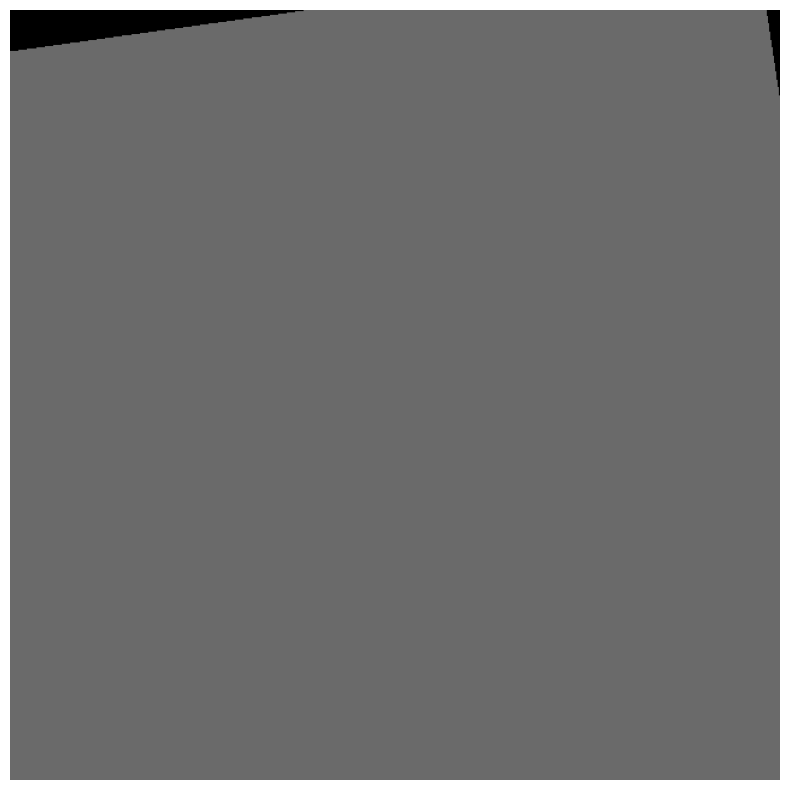


Sample 27175:
Targets shape: torch.Size([4, 5])
Targets content:
tensor([[34.0000,  0.0940,  0.5131,  0.1025,  0.1065],
        [35.0000,  0.1853,  0.5080,  0.0976,  0.1101],
        [19.0000,  0.3151,  0.5247,  0.0819,  0.1085],
        [19.0000,  0.4723,  0.9154,  0.0833,  0.1088]])
Visualizing sample with 4 targets
Box: 9h at [27, 294, 92, 362]
Box: 9s at [87, 289, 149, 360]
Box: 5s at [175, 301, 227, 370]
Box: 5s at [275, 551, 328, 620]


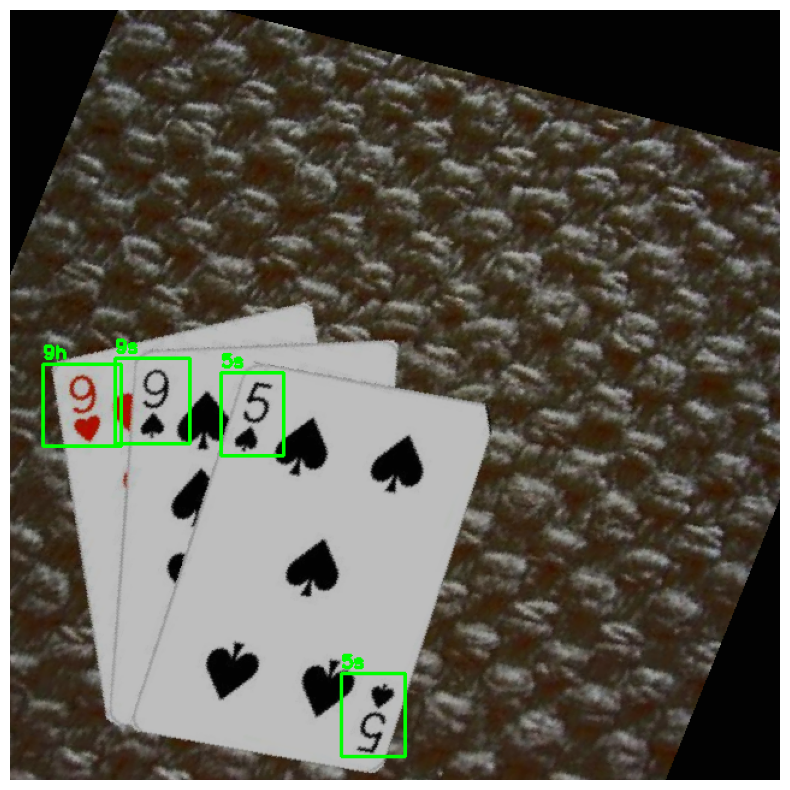

In [9]:
# --- Visualization Function ---
def visualize_sample(img_tensor, targets, class_names):
    # img_tensor: [3, H, W], float 0-1
    # targets: [N, 6] -> [idx, cls, x, y, w, h] normalized
    
    print(f"Visualizing sample with {len(targets)} targets")
    
    # Denormalize image
    img = img_tensor.permute(1, 2, 0).numpy()
    img = (img * 255).astype(np.uint8).copy()
    h, w = img.shape[:2]
    
    # Draw boxes
    for t in targets:
        cls_id = int(t[1])
        box = t[2:] # x, y, w, h normalized
        
        # Convert to xyxy absolute
        x1 = int((box[0] - box[2] / 2) * w)
        y1 = int((box[1] - box[3] / 2) * h)
        x2 = int((box[0] + box[2] / 2) * w)
        y2 = int((box[1] + box[3] / 2) * h)
        
        print(f"Box: {class_names[cls_id]} at [{x1}, {y1}, {x2}, {y2}]")
        
        # Draw rectangle
        cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)
        
        # Draw label
        label = class_names[cls_id]
        cv2.putText(img, label, (x1, y1 - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
        
    plt.figure(figsize=(10, 10))
    plt.imshow(img)
    plt.axis('off')
    plt.show()

# --- Display Examples ---
print("Displaying random augmented samples...")
indices = random.sample(range(len(dataset)), 5)

for i in indices:
    img, targets = dataset[i]
    # targets from dataset is [N, 5] -> [cls, x, y, w, h]
    
    print(f"\nSample {i}:")
    print(f"Targets shape: {targets.shape}")
    print(f"Targets content:\n{targets}")
    
    # Add dummy batch index
    targets_with_idx = torch.cat((torch.zeros((targets.shape[0], 1)), targets), dim=1)
    
    visualize_sample(img, targets_with_idx, class_names)